---
title: Voice Emotion Classification
author: Catie Baxter and Otis Milliken 
date: '2024-04-07'
description: "Final Project for CS0451"
format: html
---

Here is a link to the [dataset](https://zenodo.org/records/1188976#.XrC7a5NKjOR) with used.

The files in our dataset were named using a specific naming structure by the original authors. Each file has a unique filename that act as identifiers for the characteristics of the audio file.

There are 7 digits, divided by dashes (e.g. "02-01-06-01-02-01-12.mp4"). 

The first digit reflects the **modality**:

    01 - full-AV

    02 - video only

    03 - audio-only
    

The second digit is the vocal channel. We are only investigating the speech files so they will all be 01.

The third digit is the **emotion** which will be our target variable.

    01 - neutral

    02 - calm

    03 - happy

    04 - sad

    05 - angry

    06 - fearful
    
    07 - disgust

    08 - surprised

The fourth digit reflects the emotional intensity, which is 01 for normal and 02 for strong.

The fifth digit reflects the **statement** in the file:

    01 - "Kids are talking by the door"
    
    02 - "Dogs are sitting by the door"

The sixth digit indicates the repetition number of the study: 01 or 02.

Finally the seventh digit is the actor that spoke in the recording, labelled 01 to 24. Odd numbers are male and even numbers are female. 


In [3]:
import os
import pandas as pd
import librosa
import numpy as np
import torch


In [4]:

# assign directory

directory = "data"

dictionary = {
    'Filepath': [],
    'Modality': [],
    'Vocal_channel': [],
    'Emotion':[],
    'Emotional_intensity':[],
    'Statement':[],
    'Repetition':[],
    'Actor':[],
    'Sample':[],
    'Sample_rate': [],
    'Sex':[],
    'Mel_sgram': []
}

def parse_filename(file):
    filename = file[5:-4]
    digits = filename.split("-")
    dictionary['Modality'].append(digits[0])
    dictionary['Vocal_channel'].append(digits[1])
    dictionary['Emotion'].append(int(digits[2])-1)
    dictionary['Emotional_intensity'].append(digits[3])
    dictionary['Statement'].append(digits[4])
    dictionary['Repetition'].append(digits[5])
    dictionary['Actor'].append(digits[6])
    dictionary['Sex'].append('Female' if (int(digits[6]) % 2) == 0 else 'Male') # odd numbers are male (1), even numbers female (0)
    return 

def create_sgram(sample, sr):
    sgram = librosa.stft(sample)
    sgram_mag, _ = librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=0)
    return mel_sgram

def getting_files(directory):
    for filename in os.listdir(directory):
        file = os.path.join(directory, filename) 
        if os.path.isfile(file):
            dictionary['Filepath'].append(file)
            samples, samplerate = librosa.load(file)
            dictionary['Sample'].append(samples)
            dictionary['Sample_rate'].append(samplerate)
            dictionary['Mel_sgram'].append(create_sgram(samples, samplerate))
            parse_filename(file)

getting_files(directory)


In [5]:
from random import randint
def findMaxSize(df):
    max_row = -1
    max_column = -1
    for i, sgram in enumerate(df):
        max_column = max(sgram.shape[0], max_column)
        max_row = max(sgram.shape[1], max_row)
    return max_column, max_row

def padding_mel(sgrams, max_row, max_column):
    for i, sgram in enumerate(sgrams):
        length = max_column - len(sgram[0])
        beg_pad = randint(0, length)
        end_pad = length - beg_pad
        sgram = np.pad(sgram, ((0, 0), (0, end_pad)), mode='constant')
        sgram = np.pad(sgram, ((0, 0), (beg_pad, 0)), mode='constant')
        sgrams[i] = sgram
    return

max_row, max_column = findMaxSize(dictionary["Mel_sgram"])
padding_mel(dictionary["Mel_sgram"], max_row, max_column)
df = pd.DataFrame(dictionary)

In [6]:
print(df['Mel_sgram'][2])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Split up our Data

In the next step we split up our data

In [7]:
from sklearn.model_selection import train_test_split

data = df[["Mel_sgram", "Emotion"]]

df_train, df_test = train_test_split(data, test_size = 0.2, random_state = 123)

In [8]:
X_train = df_train["Mel_sgram"]
y_train = df_train["Emotion"]

X_test = df_test["Mel_sgram"]
y_test = df_test["Emotion"]

X_train.head()

1285    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.311127, 37....
746     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
85      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
707     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1095    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: Mel_sgram, dtype: object

In [9]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_train.head()

0    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.311127, 37....
1    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: Mel_sgram, dtype: object

In [10]:
SAMPLE_RATE = df["Sample_rate"][0]

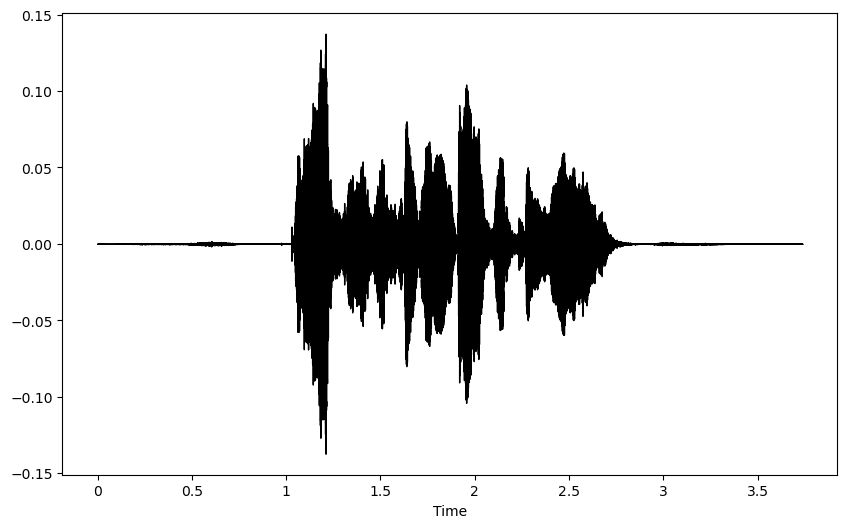

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
librosa.display.waveshow(df["Sample"][0], sr=SAMPLE_RATE, color="black")

## Creating Mel Spectogram

In [12]:
#librosa.display.specshow(X_train[0], sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
print(X_train[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


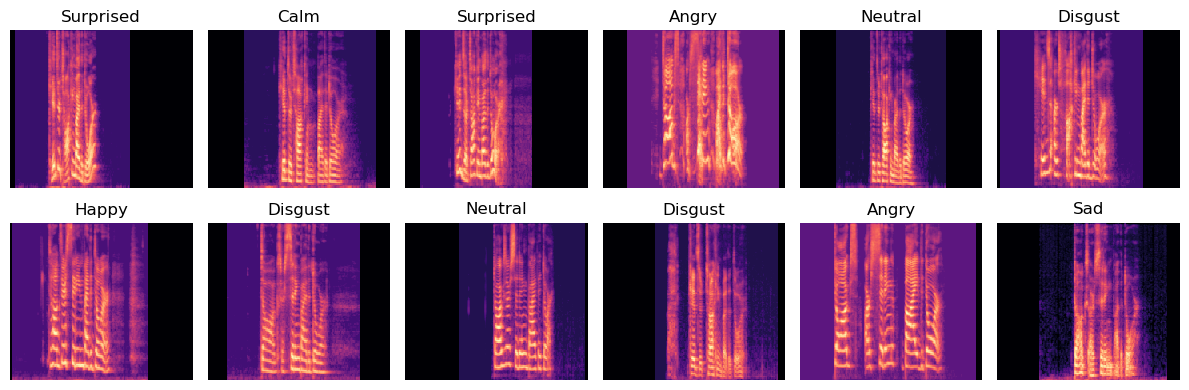

In [13]:
from matplotlib import pyplot as plt
EMOTIONS = ["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"]

def show_images(X, y, rows, cols):
    fig, axarr = plt.subplots(rows, cols, figsize = (2*cols, 2*rows))
    for i, ax in enumerate(axarr.ravel()):
        librosa.display.specshow(X[i], sr=SAMPLE_RATE, x_axis='time', y_axis='mel', ax=ax)
        ax.set(title = f"{EMOTIONS[y[i]]}")
        ax.axis("off")
    plt.tight_layout()

show_images(X_train, y_train, 2, 6)

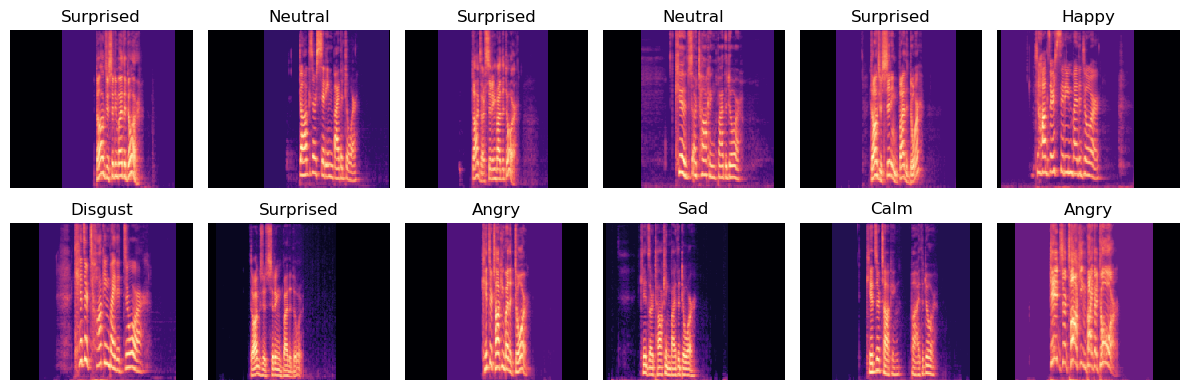

In [20]:
show_images(X_test, y_test, 2, 6)

In [14]:
print(X_train.shape)

def prep(df_X, df_y):
    y = torch.tensor(df_y.values)
    X = torch.tensor(df_X)
    print(X.shape)
    X = X.unsqueeze(1)
    return X, y

X_train_rs, y_train_rs = prep(X_train, y_train)
X_test_rs, y_test_rs = prep(X_test, y_test)

print(X_train_rs.shape)


(1152,)


/var/folders/jl/09jgt7dd3sz8vwxd15c41dp80000gn/T/ipykernel_21977/3593060238.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_5ae0635zuj/croot/pytorch-select_1700511177724/work/torch/csrc/utils/tensor_new.cpp:264.)
  X = torch.tensor(df_X)


torch.Size([1152, 128, 228])
torch.Size([288, 128, 228])
torch.Size([1152, 1, 128, 228])


In [15]:
data_loader_train = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_rs, y_train_rs),
    batch_size = 32,
    shuffle = True
)

data_loader_test = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_test_rs, y_test_rs),
    batch_size = 32,
    shuffle = True
)

In [33]:
## Convolutional Models

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}.")

X_train_rs, y_train_rs = X_train_rs.to(device), y_train_rs.to(device)
X_test_rs, y_test_rs = X_test_rs.to(device), y_test_rs.to(device)


import torch.nn as nn
from torch.nn import ReLU

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.pipeline = torch.nn.Sequential(
            # 128 x 228
            nn.Conv2d(1, 32, 3),
            # 126 x 226 x 32 
            ReLU(),
            nn.Conv2d(32, 64, 3),
            # 124 x 224 x 64
            ReLU(),
            nn.MaxPool2d(2, 2),
            # 62 x 112 x 64
            nn.Conv2d(64, 64, 3),
            # 60 x 110 x 64
            ReLU(),
            nn.MaxPool2d(2, 2),
            # 30 x 52 x 64 105600
            nn.Flatten(),
            nn.Linear(105600, 1625),
            nn.Linear(1625, 8)
        )

    def forward(self, x):
        return self.pipeline(x)
    
model = ConvNet().to(device)


Running on cpu.


In [34]:
def evaluate(model):

    # count the number of total observations and correct predictions
    total = 0
    total_correct = 0

    # loop through the data loader
    for X, y in data_loader_test:

        # move the data to the device (ideally, to gpu)
        X, y = X.to(device), y.to(device)

        # compute the predictions
        scores = model.forward(X)
        y_pred =  torch.argmax(scores, dim = 1)

        # update the total and the number of correct predictions
        total += X.size(0)
        total_correct += (y_pred == y).sum().item()

    print(f"validation accuracy = {total_correct / total:.3f}")

In [35]:
import torch.optim as optim
def train(model, k_epochs = 1, evaluate_after_epoch = True, **opt_kwargs):
    loss_fn = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(model.parameters(), **opt_kwargs)

    for epoch in range(k_epochs):
        for i, data in enumerate(data_loader_train):
            X, y = data
            X, y = X.to(device), y.to(device)

            # clear accumulated gradients
            optimizer.zero_grad()

    
            # compute the loss
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            loss.backward()
            optimizer.step()

        if evaluate_after_epoch:
            print(f"Epoch {epoch}: ", end = "")
            evaluate(model)

    

In [37]:
train(model, k_epochs = 5,  lr = 0.01, evaluate_after_epoch = True, momentum = 0.9)

In [ ]:
evaluate(model)

NameError: name 'evaluate' is not defined